<a href="https://colab.research.google.com/github/maipatana/AR788/blob/master/week_11/AR788_Week_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
_URL = 'https://ar788.s3-ap-southeast-1.amazonaws.com/Dataset100.zip'

path_to_zip = tf.keras.utils.get_file('Dataset100.zip',
                                      origin=_URL,
                                      extract=True,
                                      archive_format='zip')

data_dir = os.path.join(os.path.dirname(path_to_zip), 'Dataset100/')

7249920/7245574 [==============================] - 2s 0us/step


In [ ]:
print(data_dir)
print([i for i in os.listdir(data_dir)])

/root/.keras/datasets/Dataset100/
['rat', 'mue7', 'niwet', '.DS_Store', 'siri']


In [6]:
batch_size = 32
img_height = 100
img_width = 100

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 430 files belonging to 4 classes.
Using 344 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 430 files belonging to 4 classes.
Using 86 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['mue7', 'niwet', 'rat', 'siri']


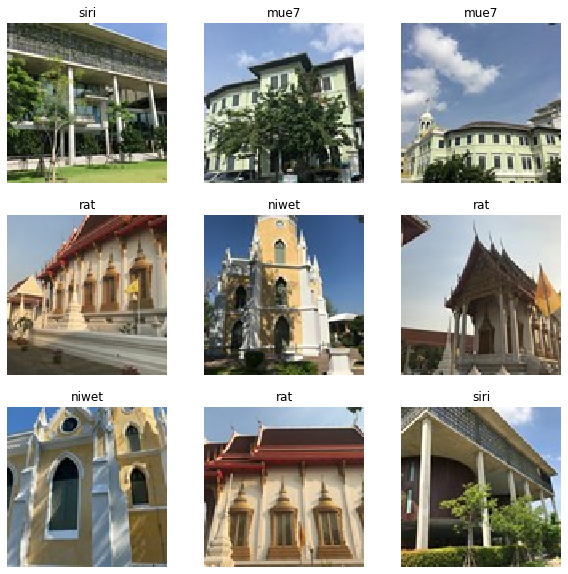

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [14]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1280032   
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 1,280,612
Trainable params: 1,280,612
Non-trainable params: 0
____________________________________________

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
11/11 [==============================] - 1s 129ms/step - loss: 2.1914 - accuracy: 0.3430 - val_loss: 1.4979 - val_accuracy: 0.4419
Epoch 2/10
11/11 [==============================] - 1s 71ms/step - loss: 1.1984 - accuracy: 0.4884 - val_loss: 0.8720 - val_accuracy: 0.7093
Epoch 3/10
11/11 [==============================] - 1s 65ms/step - loss: 0.7951 - accuracy: 0.7151 - val_loss: 0.6276 - val_accuracy: 0.8372
Epoch 4/10
11/11 [==============================] - 1s 70ms/step - loss: 0.5609 - accuracy: 0.8983 - val_loss: 0.5272 - val_accuracy: 0.9419
Epoch 5/10
11/11 [==============================] - 1s 64ms/step - loss: 0.4049 - accuracy: 0.9360 - val_loss: 0.4881 - val_accuracy: 0.8837
Epoch 6/10
11/11 [==============================] - 1s 65ms/step - loss: 0.2882 - accuracy: 0.9709 - val_loss: 0.3700 - val_accuracy: 0.9186
Epoch 7/10
11/11 [==============================] - 1s 72ms/step - loss: 0.2141 - accuracy: 0.9767 - val_loss: 0.4182 - val_accuracy: 0.8721
Epoch 8/10
1

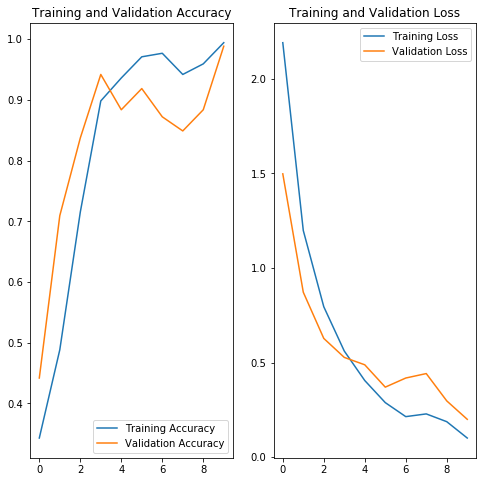

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test with an image

# Early Stopping

In [1]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
help(EarlyStopping)

In [ ]:
early_stop = EarlyStopping(monitor=?, mode='min', verbose=1, patience= ?)

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=[early_stop]
)

# Drop Out Layer

In [2]:
from tensorflow.keras.layers import Dropout

In [ ]:
help(Dropout)

In [ ]:
model = Sequential()
# สร้าง Model
model.add()



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)